### **Unzipping dataset**

In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/labels-20250212T103318Z-001.zip", "r") as zip_ref:
  zip_ref.extractall("/content/")

### **Data Exploration and Understanding**

In [ ]:
label_count = []

for filename in os.listdir("/content/labels/labels_native"):
  file_path = os.path.join("/content/labels/labels_native", filename)

  with open(file_path, "r") as f:
    lines = [line for line in f.read().splitlines() if line.strip()]
    label_count.append(len(lines))

### **How many instances of solar panels are present in the dataset?**

In [ ]:
s = 0
for i in label_count:
  s += i

print(f"No of images : {len(label_count)}")
print(f"No of instances of solar panels : {s}")

No of images : 2542
No of instances of solar panels : 29625


### **Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.**

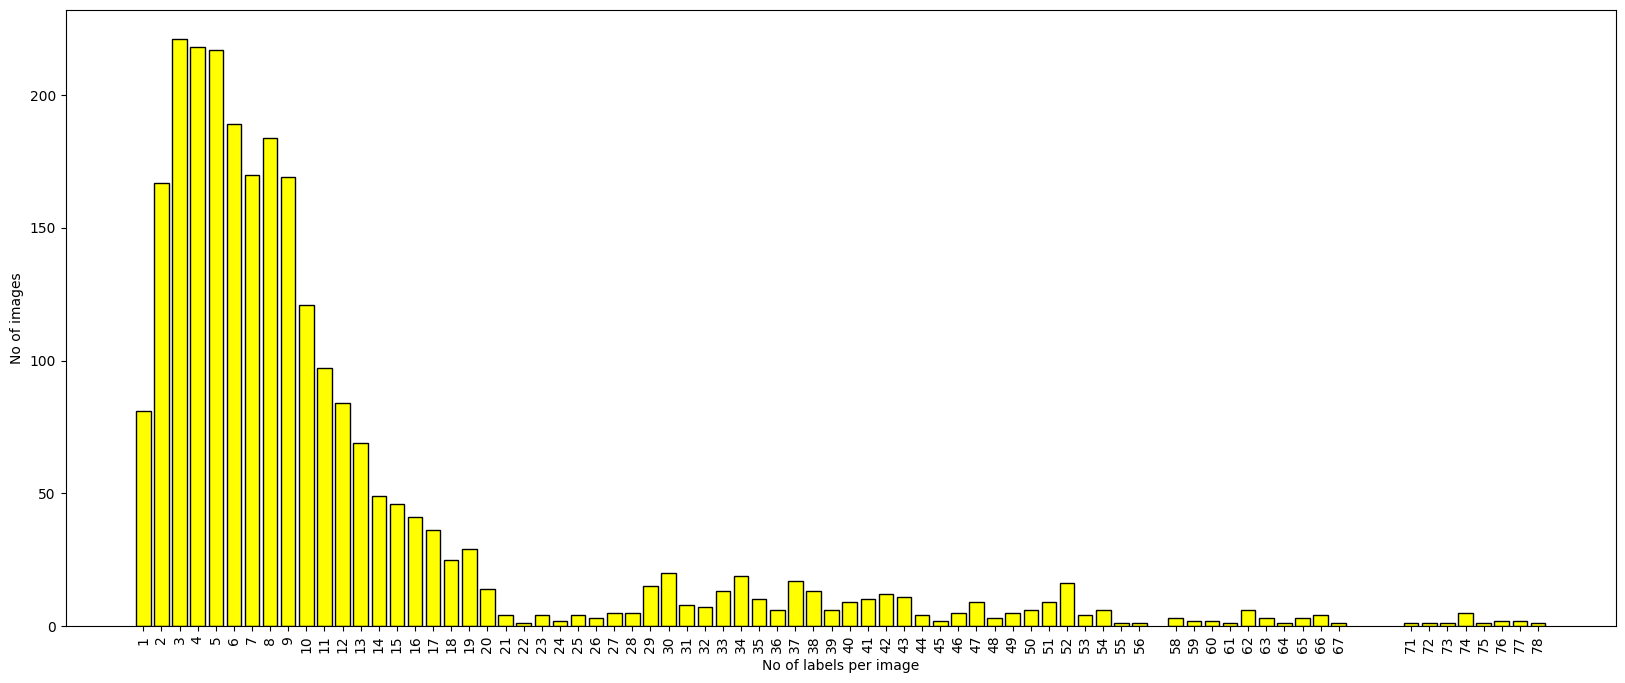

In [ ]:
import matplotlib.pyplot as plt

from collections import Counter
count_distribution = Counter(label_count)

labels = list(count_distribution.keys())
images = list(count_distribution.values())

plt.figure(figsize = (20,8))
plt.bar(labels, images, color = "yellow", edgecolor = "black")
plt.xlabel("No of labels per image")
plt.ylabel("No of images")
plt.xticks(labels, rotation = 90)
plt.show()

### **What method was used to compute the area (in meters) for a single instance?**

In [ ]:
areas = []

for filename in os.listdir("/content/labels/labels_native"):
  file_path = os.path.join("/content/labels/labels_native", filename)

  with open(file_path, "r") as f:
    lines = [line for line in f.read().splitlines() if line.strip()]

    for line in lines:
      values = line.split()

      width = float(values[3])
      height = float(values[4])

      area = width * height * 0.31 * 0.31 * 416 * 416
      areas.append(area)

### **What is the mean area and standard deviation?**

In [ ]:
import numpy as np

mean = np.mean(np.array(areas))
std = np.std(np.array(areas))

max = np.max(np.array(areas))
min = np.min(np.array(areas))

print(f"Mean of areas is : {mean} m^2")
print(f"Standard Deviation of areas is : {std} m^2")
print(f"Max of areas is : {max} m^2")
print(f"Min of areas is : {min} m^2")

Mean of areas is : 191.51782786497893 m^2
Standard Deviation of areas is : 630.7003355500087 m^2
Max of areas is : 12177.407600000002 m^2
Min of areas is : 1.0571000000000004 m^2


### **Plot the histogram of areas. What do you observe?**

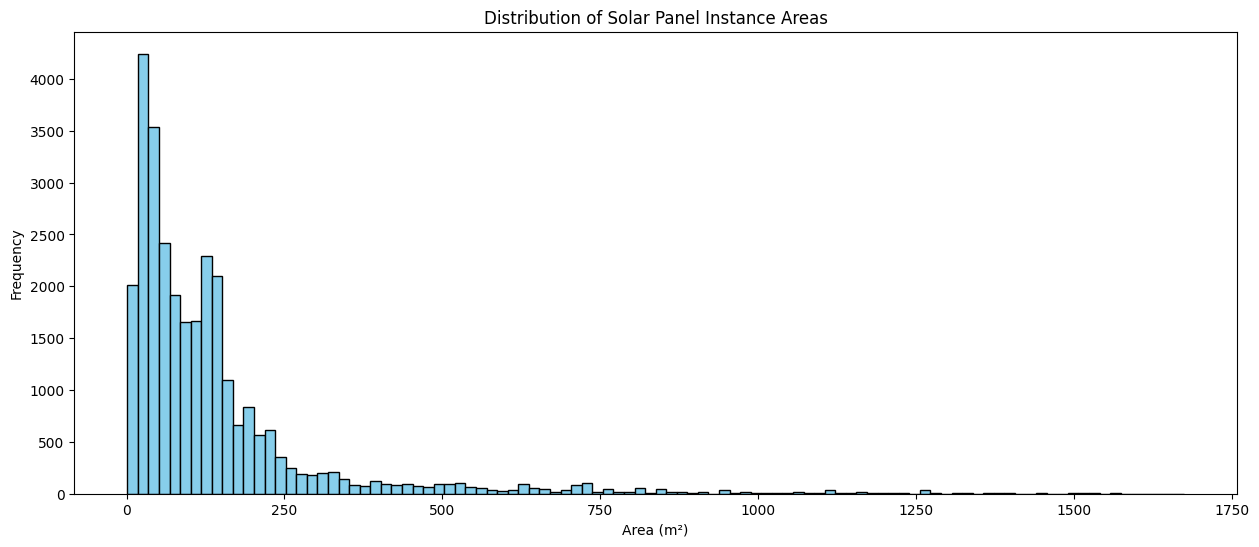

In [ ]:
cutoff = np.percentile(areas, 99)
clipped_areas = [a for a in areas if a <= cutoff]

plt.figure(figsize=(15, 6))
plt.hist(clipped_areas, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Area (m²)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Instance Areas")
plt.show()

### **Write a function to compute IoU (Intersection over Union) between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library**

In [ ]:
!pip install shapely

In [ ]:
import shapely
from shapely.geometry import Polygon

def box_to_polygon(box):

  # here box is an arary wich has [category, x center, y center, x width, y width]

  xmin = box[1] - box[3] / 2
  xmax = box[1] + box[3] / 2
  ymin = box[2] - box[4] / 2
  ymax = box[2] + box[4] / 2

  return Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

def IOU_using_shapely(box1, box2):

  polygon1 = box_to_polygon(box1)
  polygon2 = box_to_polygon(box2)

  intersection = polygon1.intersection(polygon2)
  union = polygon1.union(polygon2)

  IOU =  intersection.area / union.area

  return IOU

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import supervision as sv

def sv_format(box):

  xmin = box[1] - box[3] / 2
  xmax = box[1] + box[3] / 2
  ymin = box[2] - box[4] / 2
  ymax = box[2] + box[4] / 2

  return [xmin, ymin, xmax, ymax]


def IOU_using_sv(box1, box2):

  box1 = np.array(sv_format(box1))
  box2 = np.array(sv_format(box2))

  iou = sv.detection.utils.box_iou_batch(box1[None, :], box2[None, :])
  return iou

In [ ]:
box1 = np.array([0.0, 0.87259615, 0.70072115, 0.05769231, 0.05528846])
box2 = np.array([0.0, 0.880, 0.710, 0.050, 0.050])

In [ ]:
IOU_using_shapely(box1, box2)

0.5479150489472867

In [ ]:
IOU_using_sv(box1, box2)

array([[0.54791505]])

### **Use Pascal VOC 11 point interpolation method to implement the Average Precision (AP)**

In [ ]:
def VOC_11_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  recall_thresholds = np.linspace(0,1,11)

  ap = 0.0

  for t in recall_thresholds:
    if np.any(recalls >= t) :
      p = np.max(precisions[recalls >= t])
    else :
      p = 0.0
    ap += p

  ap /= 11
  return ap

### **Use COCO 101-point interpolation method to implement the Average Precision (AP)**

In [ ]:
def COCO_11_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  recall_thresholds = np.linspace(0, 1, 101)

  ap = 0.0

  for t in recall_thresholds:
    if np.any(recalls >= t):
      p = np.max(precisions[recalls >= t])
    else :
      p = 0.0
    ap += p

  ap /= 101
  return ap

### **Use Area under Precision-Recall Curve (AP) method to implement the Average Precision (AP)**

In [ ]:
def PR_curve_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  ap = np.trapz(precisions, recalls)
  return ap

### **Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods**

In [ ]:
def generate_random_images(num_images, image_size):

  images = []

  for _ in range(num_images):

    image = np.random.randint(0, 256, (image_size[1], image_size[0], 3))
    images.append(image)

  return images



def generate_random_boxes(num_boxes, image_size, box_size):

  boxes = []

  x_ = image_size[0] - box_size[0]
  y_ = image_size[1] - box_size[1]

  for _ in range(num_boxes):

    x_center = np.random.randint(0, x_ + 1) + box_size[0] / 2

    y_center = np.random.randint(0, y_ + 1) + box_size[1] / 2

    boxes.append([0, x_center, y_center, box_size[0], box_size[1]])

  return np.array(boxes)



def slightly_overlapping_predicted_boxes(gt_boxes, offset_range):

  pred_boxes = []

  for box in gt_boxes:

    offset_x = np.random.randint(offset_range[0], offset_range[1] + 1)
    offset_y = np.random.randint(offset_range[0], offset_range[1] + 1)

    x_center = box[1] + offset_x
    y_center = box[2] + offset_y

    pred_boxes.append([0, x_center, y_center, box[3], box[4]])

  return np.array(pred_boxes)

In [ ]:
images = generate_random_images(10, (100, 100))

pred = np.zeros((10,10))

for i in range(10):

  ground_truth_boxes = generate_random_boxes(10, (100, 100), (20, 20))
  predicted_boxes = slightly_overlapping_predicted_boxes(ground_truth_boxes, (-5,5))

  for j in range(10):

    iou = IOU_using_shapely(ground_truth_boxes[j], predicted_boxes[j])
    if iou >= 0.5:

      pred[i][j] = 1

In [ ]:
pred

array([[1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.]])

In [ ]:
Recalls = []
Precisions = []

for i in range(10):
  for j in range(10):
    value = pred[i][j]

    Recalls.append(value)
    Precisions.append(value)

In [ ]:
VOC_11_AP(Recalls, Precisions)

1.0

In [ ]:
COCO_11_AP(Recalls, Precisions)

1.0

In [ ]:
PR_curve_AP(Recalls, Precisions)

0.0

### **Split the data into 80-20 train-test split. Use 10% of training data as validation.**

In [ ]:
with zipfile.ZipFile("/content/image_chips_native-20250212T103727Z-001.zip", "r") as zip_ref:
  zip_ref.extractall("/content/")

In [ ]:
images_native = []

for filename in os.listdir("/content/image_chips_native"):
  file_path = os.path.join("/content/image_chips_native", filename)

  images_native.append(file_path)

In [ ]:
label_paths = []

for filename in os.listdir("/content/labels/labels_native"):
  file_path = os.path.join("/content/labels/labels_native", filename)

  label_paths.append(file_path)

In [ ]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(images_native[:2542], label_paths, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1)

In [ ]:
len(X_train), len(X_val), len(X_test)

(1829, 204, 509)

### **Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.9/921.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 120MB/s]


In [ ]:
base_dir = "/content/dataset"

subdirs = [
    "images/train",
    "images/val",
    "images/test",
    "labels/train",
    "labels/val",
    "labels/test"
]

for subdir in subdirs:
    dir_path = os.path.join(base_dir, subdir)
    os.makedirs(dir_path, exist_ok=True)
    print("Created:", dir_path)

Created: /content/dataset/images/train
Created: /content/dataset/images/val
Created: /content/dataset/images/test
Created: /content/dataset/labels/train
Created: /content/dataset/labels/val
Created: /content/dataset/labels/test


In [ ]:
import shutil

base_dir = "/content/dataset"

dataset_splits = {
    "train": (X_train, y_train),
    "val": (X_val, y_val),
    "test": (X_test, y_test)
}

for split, (image_paths, label_paths) in dataset_splits.items():
    img_dest = os.path.join(base_dir, f"images/{split}")
    label_dest = os.path.join(base_dir, f"labels/{split}")

    for img_path, label_path in zip(image_paths, label_paths):
        shutil.copy(img_path, img_dest)
        shutil.copy(label_path, label_dest)

print("All images and labels have been moved to their respective directories.")

All images and labels have been moved to their respective directories.


In [ ]:
data_yaml = f"""path: {base_dir}
train: images/train
val: images/val
test: images/test

nc: 1  # Number of classes (change this if you have more than 1 class)
names: ['solar panel']  # Replace 'object' with the actual class name
"""

with open(os.path.join(base_dir, "data.yaml"), "w") as f:
    f.write(data_yaml)

In [ ]:
model.train(
    data="/content/dataset/data.yaml",
    epochs=40,
    imgsz=416,
    device="cuda"
)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.2MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 1310 images, 519 backgrounds, 135 corrupt: 100%|██████████| 1829/1829 [00:01<00:00, 1136.74it/s]

train: WARNING ⚠️ /content/dataset/images/train/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/images/train/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/images/train/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/images/train/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/images/train/solarpanels_native_1__x0_1380_y0_10215_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible cla

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 16 images, 188 backgrounds, 2 corrupt: 100%|██████████| 204/204 [00:00<00:00, 1362.09it/s]

val: WARNING ⚠️ /content/dataset/images/val/solarpanels_native_2__x0_5256_y0_6824_dxdy_416.tif: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/dataset/images/val/solarpanels_native_2__x0_9772_y0_2559_dxdy_416.tif: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.24G      1.934       2.29      1.376        168        416: 100%|██████████| 106/106 [00:10<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        202         89     0.0318      0.191     0.0206     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.14G      1.726      1.727      1.227        159        416: 100%|██████████| 106/106 [00:09<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 11.42it/s]

                   all        202         89     0.0204      0.348     0.0162     0.0074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.14G      1.666      1.584      1.213        190        416: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.53it/s]

                   all        202         89     0.0337      0.236     0.0182    0.00817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.12G      1.569      1.422      1.165         89        416: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]


                   all        202         89     0.0416      0.393     0.0322     0.0162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.07G      1.557      1.429      1.166        261        416: 100%|██████████| 106/106 [00:08<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.21it/s]


                   all        202         89      0.048      0.292     0.0335     0.0167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.26G      1.492      1.352      1.152        193        416: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.36it/s]


                   all        202         89      0.031      0.404     0.0302     0.0161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.22G      1.449      1.292      1.129        157        416: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.43it/s]


                   all        202         89     0.0392      0.337     0.0262     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.21G      1.434      1.288      1.115        160        416: 100%|██████████| 106/106 [00:08<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all        202         89     0.0461      0.404     0.0362     0.0197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.15G      1.412      1.265      1.106        119        416: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


                   all        202         89     0.0313      0.371     0.0226     0.0117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.13G      1.358      1.239      1.091        161        416: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.93it/s]

                   all        202         89     0.0445      0.146     0.0286     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.25G      1.368      1.231      1.091        120        416: 100%|██████████| 106/106 [00:08<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]


                   all        202         89     0.0245      0.371      0.021     0.0128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.24G      1.341      1.206      1.076        145        416: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]


                   all        202         89     0.0394      0.449     0.0298     0.0174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.29G      1.285      1.147      1.056        223        416: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]

                   all        202         89     0.0419      0.191     0.0341     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.24G      1.277       1.18      1.051        175        416: 100%|██████████| 106/106 [00:08<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

                   all        202         89     0.0355      0.213     0.0263     0.0154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.11G      1.292      1.154      1.053        119        416: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.18it/s]

                   all        202         89     0.0306      0.573     0.0294     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.22G      1.263      1.134      1.045         77        416: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

                   all        202         89      0.045      0.281     0.0329     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.43G      1.231      1.055      1.031         75        416: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.44it/s]


                   all        202         89     0.0394      0.393     0.0298     0.0185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.05G      1.247      1.124      1.023        147        416: 100%|██████████| 106/106 [00:08<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]

                   all        202         89     0.0454      0.404     0.0344     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.25G      1.218      1.064      1.025        182        416: 100%|██████████| 106/106 [00:08<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.74it/s]

                   all        202         89     0.0467      0.382     0.0359     0.0221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.17G      1.215      1.071       1.02        154        416: 100%|██████████| 106/106 [00:08<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.65it/s]

                   all        202         89     0.0494      0.348     0.0415     0.0258


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.16G      1.158      1.086      1.008         71        416: 100%|██████████| 106/106 [00:09<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


                   all        202         89     0.0465      0.483     0.0382     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.03G      1.127      1.046     0.9999         92        416: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.87it/s]

                   all        202         89     0.0445      0.315     0.0354     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.02G      1.122      1.067     0.9969         60        416: 100%|██████████| 106/106 [00:08<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.27it/s]

                   all        202         89     0.0458      0.337     0.0393     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.05G      1.102      1.039      0.992         47        416: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]

                   all        202         89       0.05       0.36     0.0396     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.07G      1.084      1.014     0.9865         39        416: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

                   all        202         89     0.0435       0.36     0.0365     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.09G      1.081       1.04      0.974         99        416: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.07it/s]

                   all        202         89     0.0511      0.472     0.0432     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.06G      1.072      1.026     0.9698         73        416: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.00it/s]

                   all        202         89     0.0538      0.539     0.0452     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.959G      1.062      1.028     0.9677        175        416: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

                   all        202         89     0.0516      0.551     0.0435     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.04G       1.03      1.007     0.9642        168        416: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.40it/s]

                   all        202         89     0.0519      0.562     0.0437     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.963G      1.037     0.9971     0.9619         97        416: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 14.17it/s]

                   all        202         89     0.0435      0.416     0.0388     0.0254



30 epochs completed in 0.084 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


                   all        202         89     0.0537      0.539     0.0455     0.0289
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cfb57505f50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

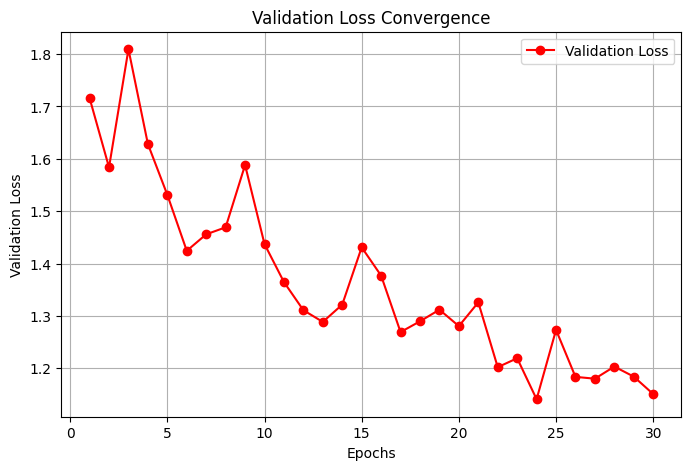

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_csv = "/content/runs/detect/train/results.csv"

df = pd.read_csv(results_csv)

plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["val/box_loss"], marker="o", label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Convergence")
plt.legend()
plt.grid()
plt.show()

### **Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.**


image 1/1 /content/image_chips_native/solarpanels_native_3__x0_7689_y0_9433_dxdy_416.tif: 416x416 5 solar panels, 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


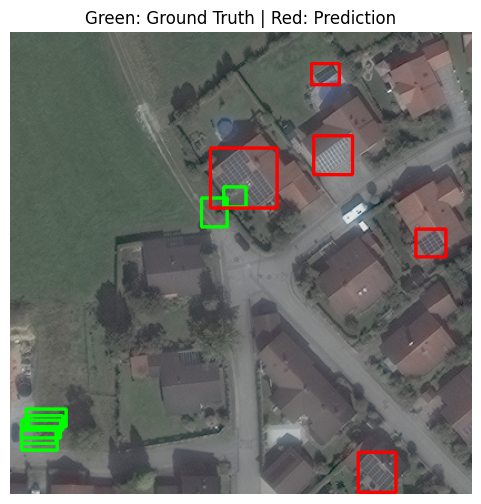

In [ ]:
import random
import cv2

model = YOLO("/content/runs/detect/train/weights/best.pt")

def load_yolo_labels(label_path):

    with open(label_path, "r") as file:
        labels = file.readlines()

    boxes = []
    for label in labels:

        parts = list(map(float, label.strip().split()))
        class_id, x_center, y_center, width, height = parts
        boxes.append((class_id, x_center, y_center, width, height))

    return boxes

num_samples = 1
random_indices = random.sample(range(len(X_test)), num_samples)
selected_images = [X_test[i] for i in random_indices]
selected_labels = [y_test[i] for i in random_indices]


GT_COLOR = (0, 255, 0)
PRED_COLOR = (255, 0, 0)

for img_path, label_path in zip(selected_images, selected_labels):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    gt_boxes = load_yolo_labels(label_path)

    results = model(img_path)[0]

    for gt in gt_boxes:

        _, x, y, w, h = gt
        x1, y1 = int((x - w / 2) * width), int((y - h / 2) * height)
        x2, y2 = int((x + w / 2) * width), int((y + h / 2) * height)

        cv2.rectangle(img, (x1, y1), (x2, y2), GT_COLOR, 2)

    for pred in results.boxes.xyxy.cpu().numpy():

        x1, y1, x2, y2 = map(int, pred[:4])
        cv2.rectangle(img, (x1, y1), (x2, y2), PRED_COLOR, 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Green: Ground Truth | Red: Prediction")
    plt.show()

### **Compute mAP50 with supervision and compare with your implementation. What do you observe**

In [ ]:
test_img_paths = sorted([os.path.join("/content/dataset/images/test", f)
                           for f in os.listdir("/content/dataset/images/test")])

test_label_paths = sorted([os.path.join("/content/dataset/labels/test", f)
                             for f in os.listdir("/content/dataset/labels/test")])
img_size = (416, 416)

model = YOLO("/content/runs/detect/train/weights/best.pt")  # Update path as needed

# -------------------------------
# Helper: Load ground truth labels from a YOLO-format text file and convert to VOC format, then to sv.Detections
# -------------------------------
def load_gt_detections(label_path, img_size=(416,416)):
    # Each line in the label file: [class, x_center, y_center, width, height] (all normalized)
    gt_boxes = []
    gt_class_ids = []
    with open(label_path, "r") as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            if len(parts) != 5:
                continue
            cls, x_center, y_center, w, h = parts
            # Convert to VOC format:
            xmin = (x_center - w/2) * img_size[0]
            ymin = (y_center - h/2) * img_size[1]
            xmax = (x_center + w/2) * img_size[0]
            ymax = (y_center + h/2) * img_size[1]
            gt_boxes.append([xmin, ymin, xmax, ymax])
            gt_class_ids.append(int(cls))
    if len(gt_boxes) == 0:
        return sv.Detections(xyxy=np.empty((0,4)), class_id=np.empty((0,)), confidence=np.empty((0,)))
    return sv.Detections(xyxy=np.array(gt_boxes), class_id=np.array(gt_class_ids), confidence=np.ones(len(gt_boxes)))

# -------------------------------
# Helper: Convert YOLO model predictions to sv.Detections
# -------------------------------
def convert_pred_to_detections(result):
    # result.boxes.xyxy: predicted boxes in VOC format (absolute coordinates)
    # result.boxes.conf: confidence scores
    # result.boxes.cls: predicted class indices
    if len(result.boxes) == 0:
        return sv.Detections(xyxy=np.empty((0,4)), class_id=np.empty((0,)), confidence=np.empty((0,)))
    xyxy = result.boxes.xyxy.cpu().numpy()
    confidences = result.boxes.conf.cpu().numpy()
    class_ids = result.boxes.cls.cpu().numpy().astype(int)
    return sv.Detections(xyxy=xyxy, class_id=class_ids, confidence=confidences)

# -------------------------------
# Run predictions on the test set and prepare detections
# -------------------------------
all_gt = []    # List of sv.Detections for ground truths per image
all_preds = [] # List of sv.Detections for predictions per image

for img_path, label_path in zip(test_img_paths, test_label_paths):
    # Run prediction on the image
    results = model.predict(source=img_path, conf=0.1, iou=0.5)  # use low conf to capture all predictions
    result = results[0]  # since we process one image at a time
    preds = convert_pred_to_detections(result)
    all_preds.append(preds)
    gt = load_gt_detections(label_path, img_size=img_size)
    all_gt.append(gt)

# -------------------------------
# Compute a table of Precision, Recall, and F1 scores
# for different IoU and confidence thresholds using supervision.metrics.ConfusionMatrix
# -------------------------------
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Prepare an empty DataFrame
table = pd.DataFrame(index=[f"IoU {thr}" for thr in iou_thresholds],
                     columns=[f"Conf {thr}" for thr in conf_thresholds])

for iou_thr in iou_thresholds:
    for conf_thr in conf_thresholds:
        TP_total, FP_total, FN_total = 0, 0, 0
        # Evaluate per image
        for gt_det, pred_det in zip(all_ground_truths, all_detections):
            # Filter predictions manually by confidence threshold:
            mask = pred_det.confidence >= conf_thr
            if mask.size > 0:
                filtered_xyxy = pred_det.xyxy[mask]
                filtered_conf = pred_det.confidence[mask]
                filtered_cls = pred_det.class_id[mask]
                pred_filtered = sv.Detections(xyxy=filtered_xyxy, confidence=filtered_conf, class_id=filtered_cls)
            else:
                pred_filtered = sv.Detections(xyxy=np.empty((0,4)), confidence=np.empty((0,)), class_id=np.empty((0,)))

            # Compute confusion matrix using supervision.metrics.ConfusionMatrix.from_detections
            cm = sv.metrics.ConfusionMatrix.from_detections(
                detections=pred_filtered,
                ground_truths=gt_det,
                iou_threshold=iou_thr,
                class_mapping={0:0}
            )
            TP_total += cm.tp.sum()
            FP_total += cm.fp.sum()
            FN_total += cm.fn.sum()

        precision_val = TP_total / (TP_total + FP_total + 1e-6)
        recall_val = TP_total / (TP_total + FN_total + 1e-6)
        f1_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-6)
        table.loc[f"IoU {iou_thr}", f"Conf {conf_thr}"] = f"P: {precision_val:.3f}, R: {recall_val:.3f}, F1: {f1_val:.3f}"


print("Precision, Recall, F1-score Table:")
print(table)

# -------------------------------
# Compute mAP@50 using supervision.metrics
# -------------------------------
from supervision.metrics.pascal_voc import mean_average_precision_from_detections

# Concatenate detections and ground truths from all test images
agg_preds = sv.Detections.concatenate(all_preds)
agg_gt = sv.Detections.concatenate(all_gt)
# Filter predictions with a very low confidence threshold to include all detections
agg_preds = agg_preds.filter_by_confidence(0.001)

map50_supervision = mean_average_precision_from_detections(
    detections=agg_preds,
    ground_truths=agg_gt,
    iou_threshold=0.5,
    class_mapping={0: 0}
)

print(f"Supervision mAP@50: {map50_supervision:.4f}")


image 1/1 /content/dataset/images/test/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: 416x416 15 solar panels, 7.8ms
Speed: 0.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images/test/solarpanels_native_1__x0_10055_y0_11061_dxdy_416.tif: 416x416 7 solar panels, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images/test/solarpanels_native_1__x0_10153_y0_11089_dxdy_416.tif: 416x416 10 solar panels, 7.5ms
Speed: 0.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images/test/solarpanels_native_1__x0_10336_y0_10994_dxdy_416.tif: 416x416 4 solar panels, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/images/test/solarpanels_native_1__x0_1035_y0_8255_dxdy_416.tif: 416x416 9 solar panels, 7.5ms
S

NameError: name 'all_ground_truths' is not defined

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

model.predict()

In [ ]:
precisions = df["metrics/precision(B)"]
recalls = df["metrics/recall(B)"]

In [ ]:
VOC_11_AP(recalls, precisions)

0.09597454545454545

In [ ]:
COCO_11_AP(recalls, precisions)

0.09710495049504946

### **Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1)**